In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/yannikc/ML4H_project2.git

Cloning into 'ML4H_project2'...
remote: Enumerating objects: 13339, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 13339 (delta 19), reused 59 (delta 11), pack-reused 13270 (from 1)
Receiving objects: 100% (13339/13339), 2.09 GiB | 22.93 MiB/s, done.
Resolving deltas: 100% (1267/1267), done.
Updating files: 100% (23503/23503), done.


In [4]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.4 MB/s e

# Part 2: Pneumonia Prediction

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms

import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

### Q4 Grad-CAM (5 Pts)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
model = CNN()

# Load saved model
model.load_state_dict(torch.load("ML4H_project2/part2_cnn_weights/randomized_CNN_weights.pth", weights_only=True,map_location=torch.device('cpu')))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    img = cv2.resize(img, (1000, 1000))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram Equalization
    img = cv2.equalizeHist(img)

    # Gaussian Blur (5x5 kernel)
    final_img = cv2.GaussianBlur(img, (5, 5), 0)

    return final_img

In [15]:
# Testing label of a single image

input_img = preprocess_image("ML4H_project2/data_part2/train/PNEUMONIA/person1228_virus_2079.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)

# Note that 0 = NORMAL, 1 = PNEUMONIA
output = model(input_img)
predicted = (output > 0.5).float()
print("Predicted:", predicted.item())
print(output)

Predicted: 1.0
tensor([[0.7542]], grad_fn=<SigmoidBackward0>)


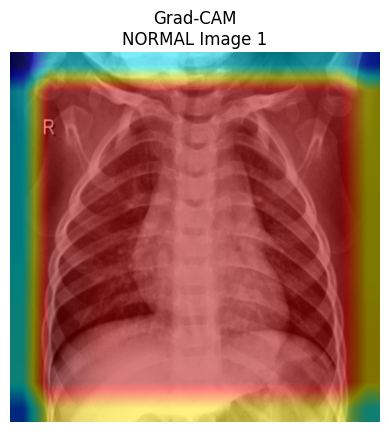

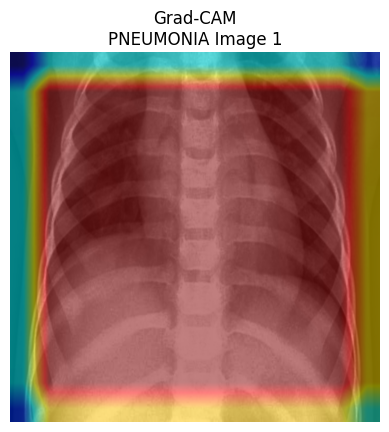

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Images used for displaying Grad-CAM:
normal_images = [
    "IM-0117-0001.jpeg",
    "IM-0119-0001.jpeg",
    "IM-0129-0001.jpeg",
    "IM-0147-0001.jpeg",
    "IM-0176-0001.jpeg"
]
pneumonia_images = [
    "person1_bacteria_1.jpeg",
    "person2_bacteria_3.jpeg",
    "person3_bacteria_12.jpeg",
    "person460_virus_948.jpeg",
    "person1228_virus_2079.jpeg"
]

base_dir = "ML4H_project2/data_part2_processed/train"
output_dir = "ML4H_project2/grad-cam-results"
os.makedirs(output_dir, exist_ok=True)

transform = transforms.ToTensor()
target_layers = [model.conv4]
targets = [ClassifierOutputTarget(0)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    for cls, image_list in [("NORMAL", normal_images), ("PNEUMONIA", pneumonia_images)]:
        for idx, fname in enumerate(image_list, start=1):
            # Load and resize
            img_path = os.path.join(base_dir, cls, fname)
            original_img = Image.open(img_path)
            resized_img = original_img.resize((224, 224))
            input_tensor = transform(resized_img).unsqueeze(0)

            # Compute Grad-CAM
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

            # Overlay the CAM on the original image
            cam_up = cv2.resize(grayscale_cam, original_img.size)
            original_np = np.float32(original_img) / 255.0
            original_rgb = np.stack([original_np] * 3, axis=-1)
            cam_on_original = show_cam_on_image(original_rgb, cam_up, use_rgb=True)

            # Save result
            out_name = f"{cls.lower()}_{idx:02d}_gradcam.png"
            cv2.imwrite(os.path.join(output_dir, out_name), cam_on_original)

            # (Optional) display the first one of each class
            if idx == 1:
                plt.imshow(cam_on_original)
                plt.title(f"Grad-CAM\n{cls} Image {idx}")
                plt.axis('off')
                plt.show()


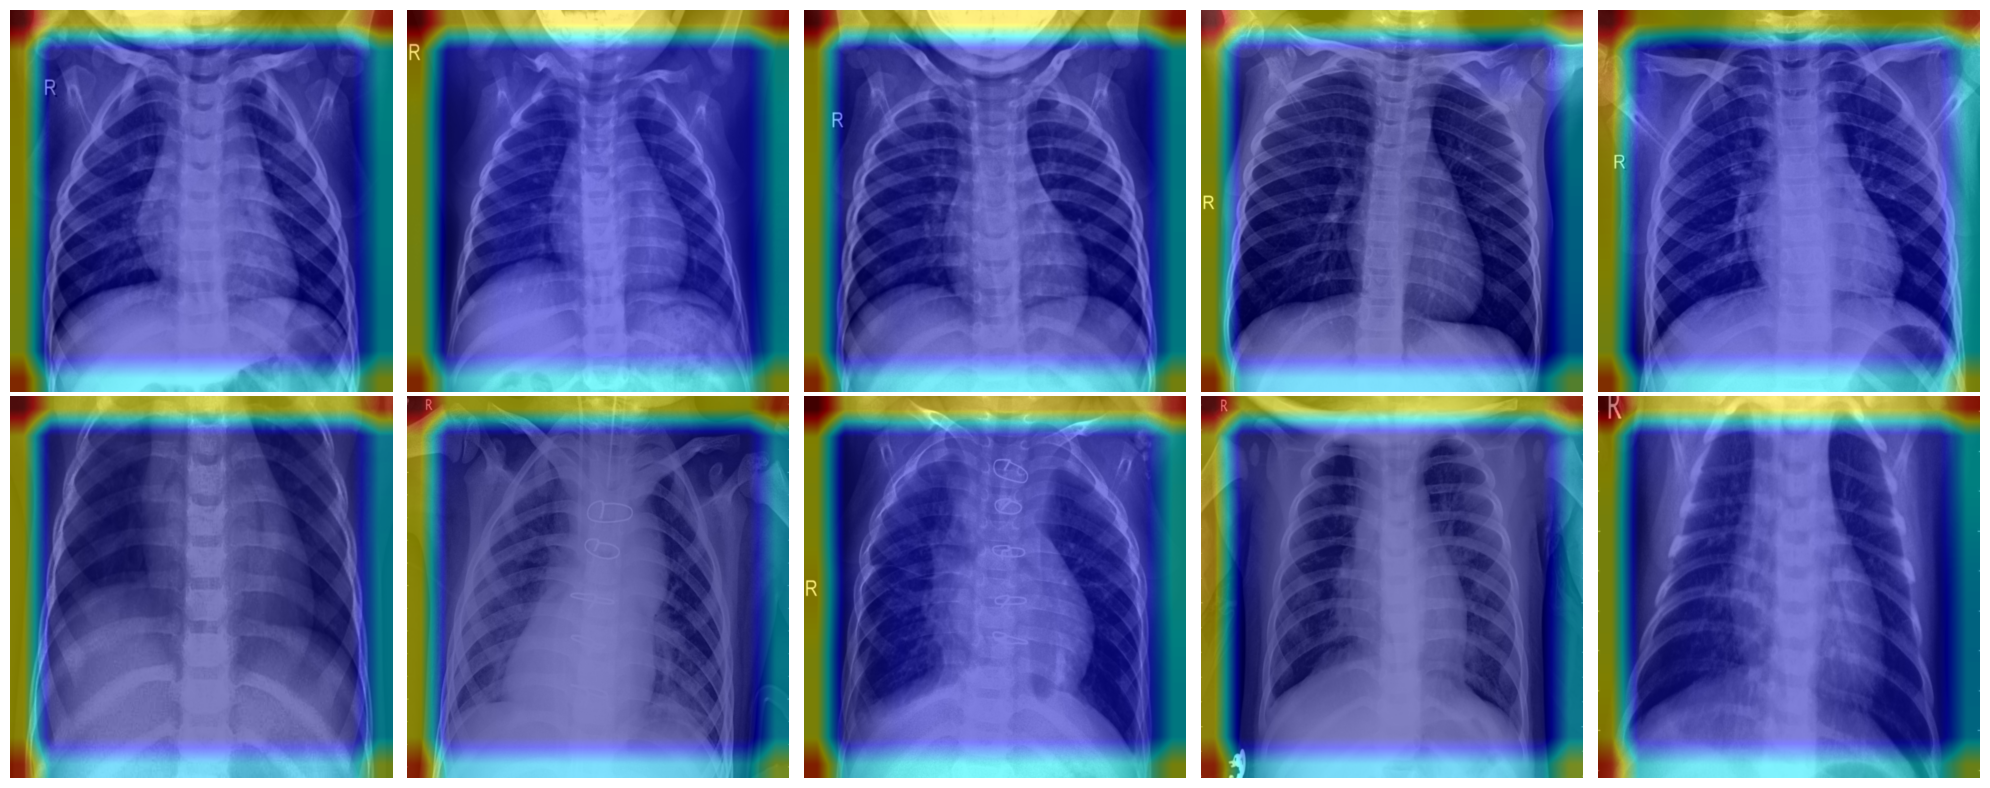

In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Plotting Grad-CAM for 5 normal and 5 pneumonia images
image_dir = "ML4H_project2/grad-cam-results"

# 1) List only .png files
image_files = sorted([
    f for f in os.listdir(image_dir)
    if os.path.isfile(os.path.join(image_dir, f))
       and f.lower().endswith('.png')
])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, image_file in enumerate(image_files):
    # 2) Stop once we've filled all subplots
    if idx >= len(axes):
        break

    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path)

    axes[idx].imshow(img)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()
